In [1]:
import sys
import os

sys.path.append(os.path.abspath(".."))

# 1. Dataset Introduction & Loading

The dataset `short_seasonal.csv` is a synthetic time series created for testing purposes. The data generation process is documented in `src/synthetic_data_generation.ipynb`.

This dataset was designed to be small and computationally lightweight, making it ideal for rapid experimentation. Its short length and strong seasonal pattern introduce unique challenges for data-intensive models, particularly those that struggle with limited training data or insufficient seasonality adaptation.

### Basic Information
- **Granularity:** Monthly
- **Length:** 80 records
- **Features:** Univariate, Seasonality

## Loading the Dataset

In [5]:
import pandas as pd
import numpy as np

train = pd.DataFrame(np.load('../data/quality_control/train.npy'))
test = pd.DataFrame(np.load('../data/quality_control/test.npy'))

train.describe().T

,count,mean,std,min,25%,50%,75%,max
0,2821.0,-0.943302,0.028377,-1.0,-0.96889,-0.955556,-0.915556,-0.84
1,2821.0,0.037575,0.190201,0.0,0.00000,0.000000,0.000000,1.00
2,2821.0,0.007444,0.085973,0.0,0.00000,0.000000,0.000000,1.00
3,2821.0,0.029777,0.170001,0.0,0.00000,0.000000,0.000000,1.00
4,2821.0,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.00
5,2821.0,0.169089,0.374897,0.0,0.00000,0.000000,0.000000,1.00
6,2821.0,0.129032,0.335295,0.0,0.00000,0.000000,0.000000,1.00
7,2821.0,0.001418,0.037635,0.0,0.00000,0.000000,0.000000,1.00
8,2821.0,0.000709,0.026622,0.0,0.00000,0.000000,0.000000,1.00
9,2821.0,0.000709,0.026622,0.0,0.00000,0.000000,0.000000,1.00


## Preprocessing

(2821, 18)


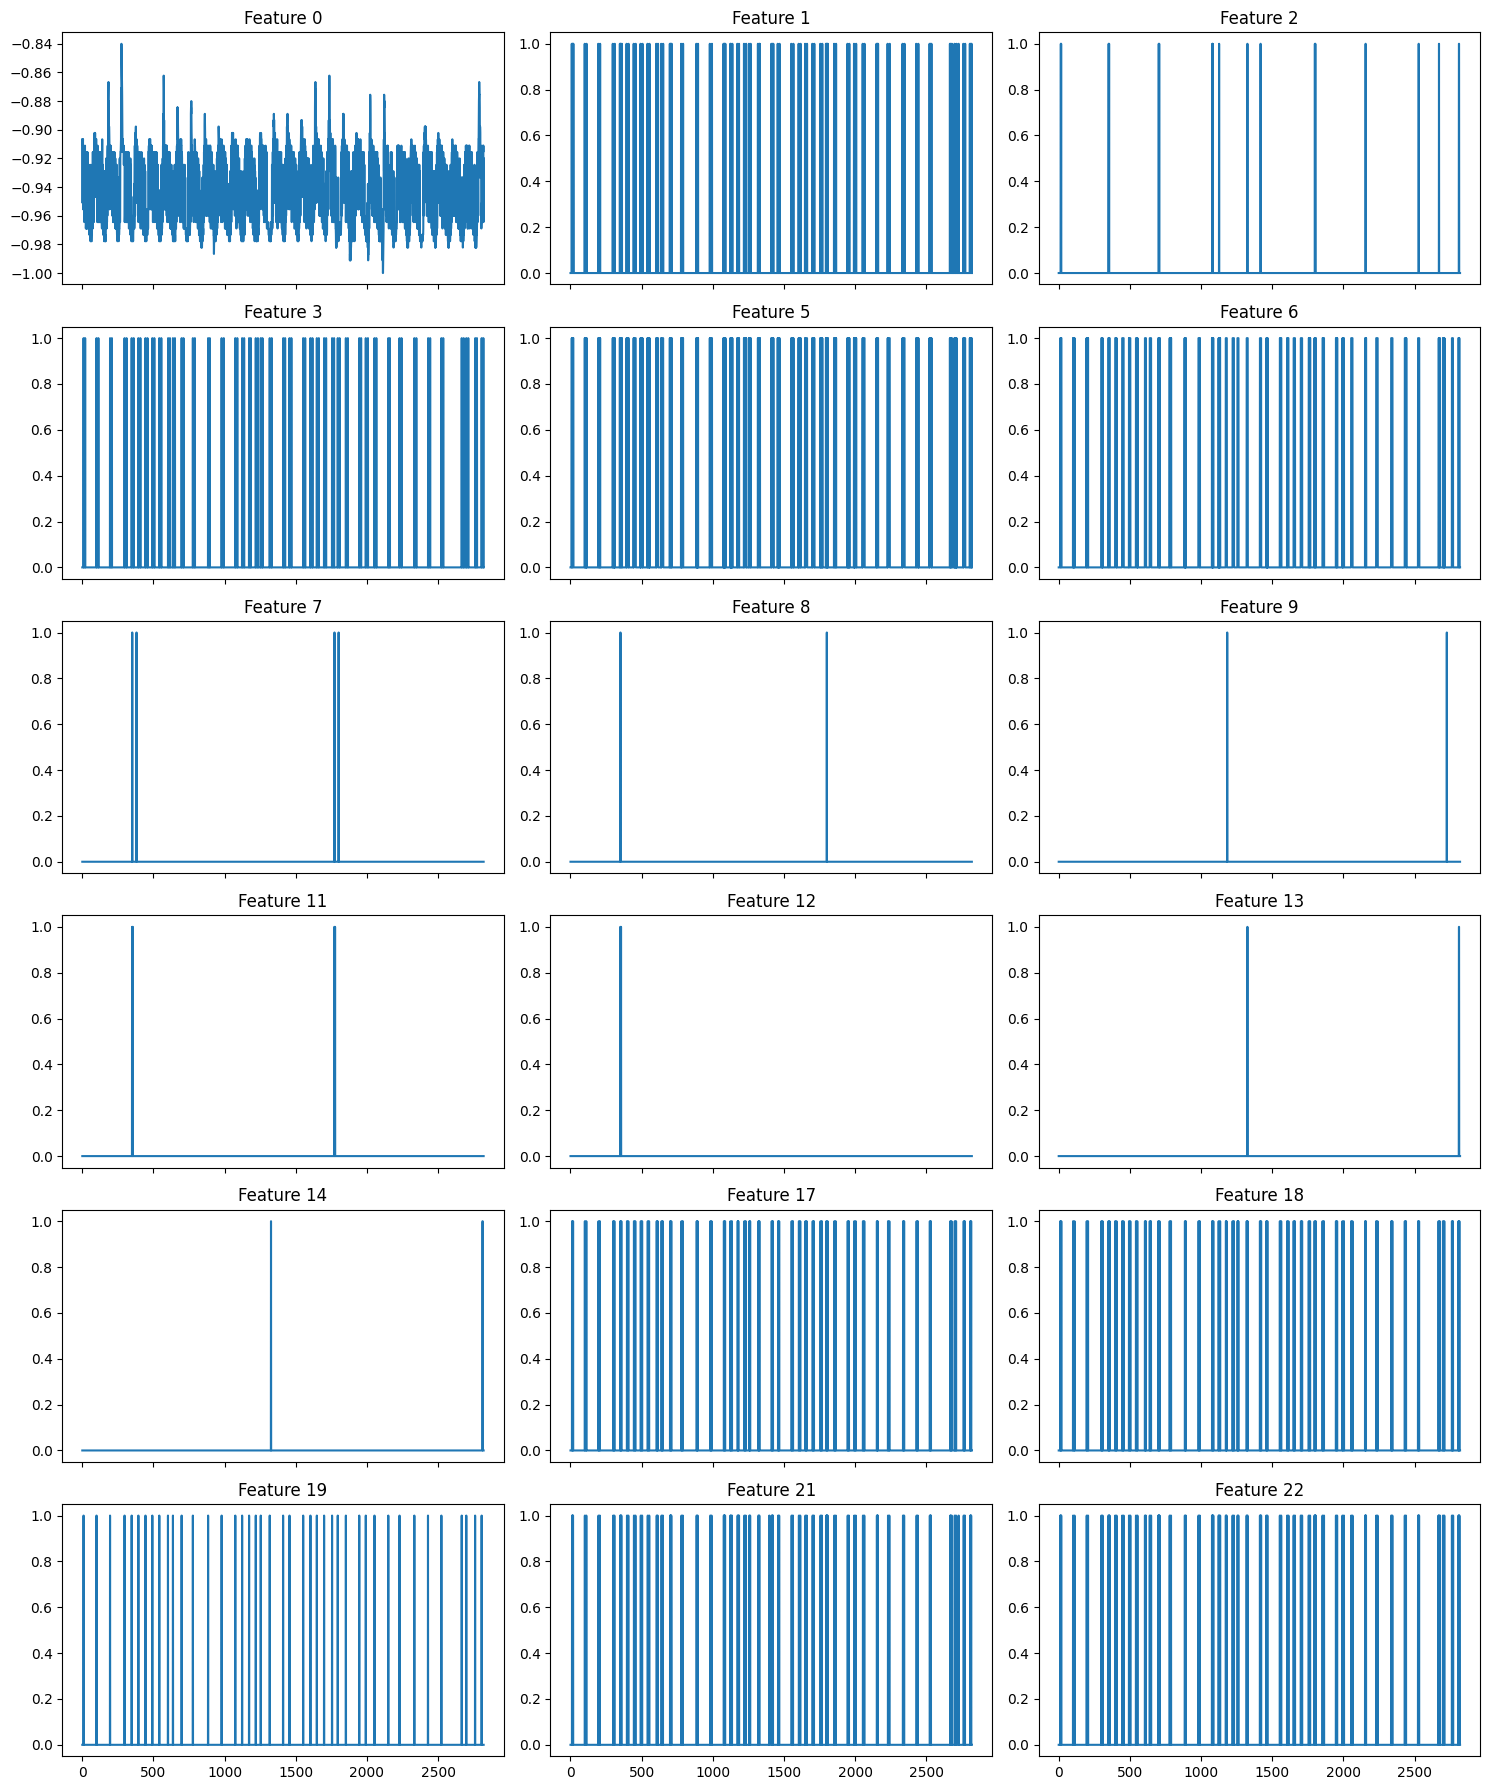

In [3]:
from src.visualization.plots import plot_multi_variate

constant_features = train.columns[train.std() == 0]
df = train.loc[:, train.std() != 0]

print(df.shape)
plot_multi_variate(df)

In [4]:
unique_vals = df.nunique()
binary_cols = unique_vals[unique_vals <= 2].index.tolist()

print(f'{len(binary_cols)} binary columns found: {binary_cols}')

17 binary columns found: [1, 2, 3, 5, 6, 7, 8, 9, 11, 12, 13, 14, 17, 18, 19, 21, 22]


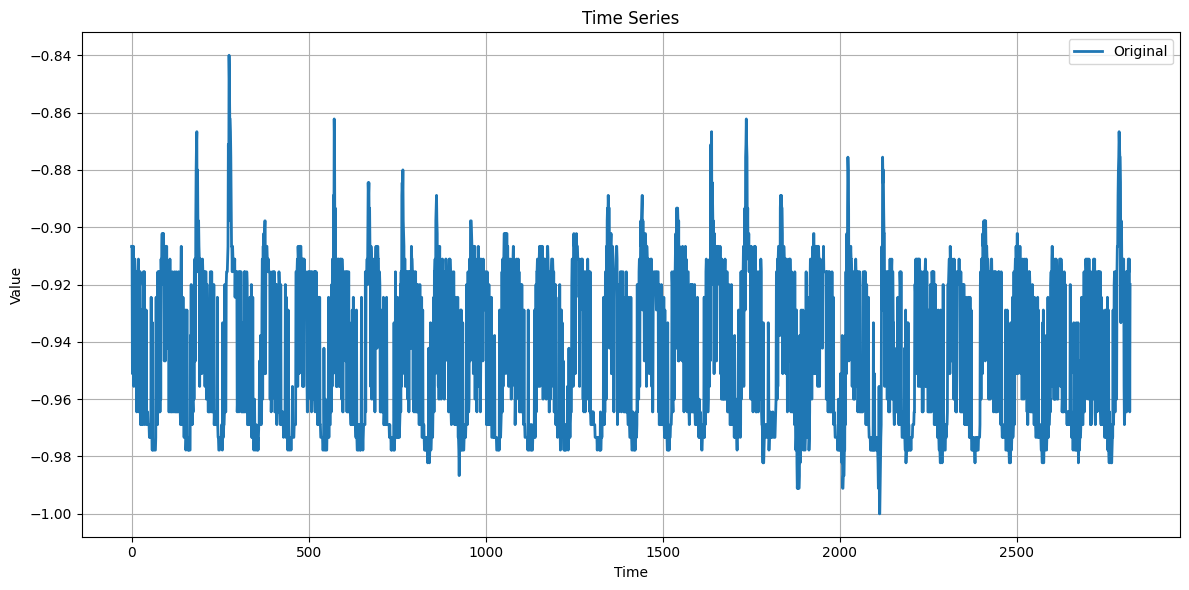

In [5]:
from src.visualization.plots import plot_ts

plot_ts(df[0])

### Binary compressions

<Axes: >

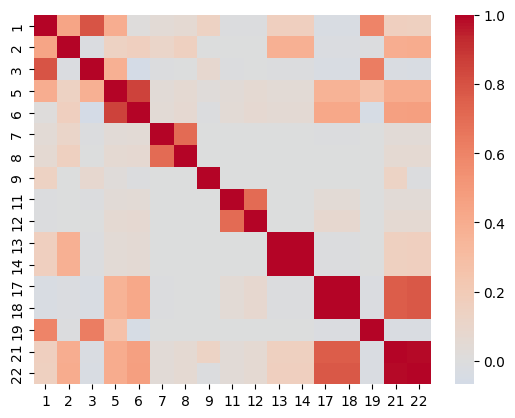

In [6]:
import seaborn as sns

corr = df.iloc[:, 1:].corr()
sns.heatmap(corr, cmap='coolwarm', center=0)


In [7]:
print(df.columns[1:18])

Index([1, 2, 3, 5, 6, 7, 8, 9, 11, 12, 13, 14, 17, 18, 19, 21, 22], dtype='int64')


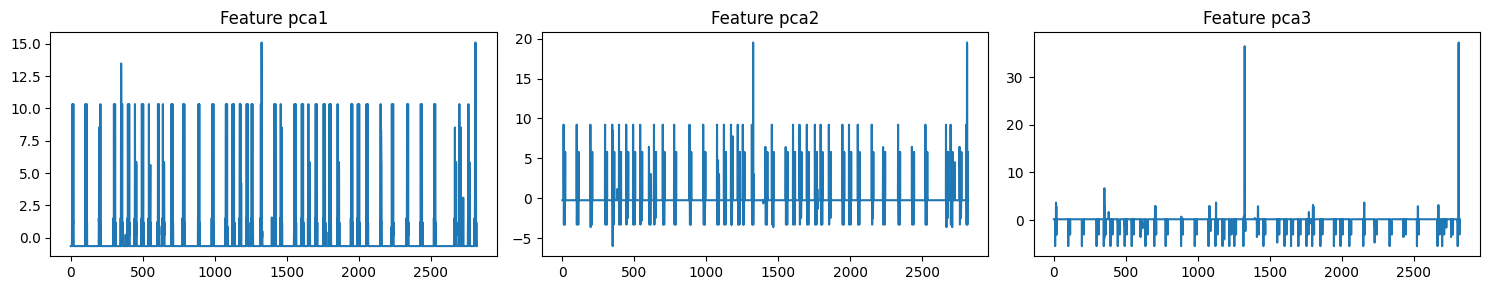

,count,mean,std,min,25%,50%,75%,max
0,2821.0,-9.433018e-01,0.028377,-1.000000,-0.968890,-0.955556,-0.915556,-0.840000
1,2821.0,3.757533e-02,0.190201,0.000000,0.000000,0.000000,0.000000,1.000000
2,2821.0,7.444169e-03,0.085973,0.000000,0.000000,0.000000,0.000000,1.000000
3,2821.0,2.977667e-02,0.170001,0.000000,0.000000,0.000000,0.000000,1.000000
5,2821.0,1.690890e-01,0.374897,0.000000,0.000000,0.000000,0.000000,1.000000
6,2821.0,1.290323e-01,0.335295,0.000000,0.000000,0.000000,0.000000,1.000000
7,2821.0,1.417937e-03,0.037635,0.000000,0.000000,0.000000,0.000000,1.000000
8,2821.0,7.089685e-04,0.026622,0.000000,0.000000,0.000000,0.000000,1.000000
9,2821.0,7.089685e-04,0.026622,0.000000,0.000000,0.000000,0.000000,1.000000
11,2821.0,1.417937e-03,0.037635,0.000000,0.000000,0.000000,0.000000,1.000000


In [8]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
pca = PCA(n_components=3)

scaled_data = scaler.fit_transform(df.iloc[:, 1:18])
pca_result = pca.fit_transform(scaled_data)
df.loc[:, ['pca1', 'pca2', 'pca3']] = pca_result

plot_multi_variate(df[['pca1', 'pca2', 'pca3']])
df.describe().T

In [9]:
scaled_test = scaler.transform(test.loc[:, df.columns[1:18]])
test.loc[:, ['pca1', 'pca2', 'pca3']] = pca.transform(scaled_test)

# plot_multi_variate(test[['pca1', 'pca2', 'pca3']])
# test.describe().T

# 2.  Classical Statistical Methods

## Multivariate Normal


Minimum training score: -408.4699414421761
First Percentile cutoff: -25.29245696151591


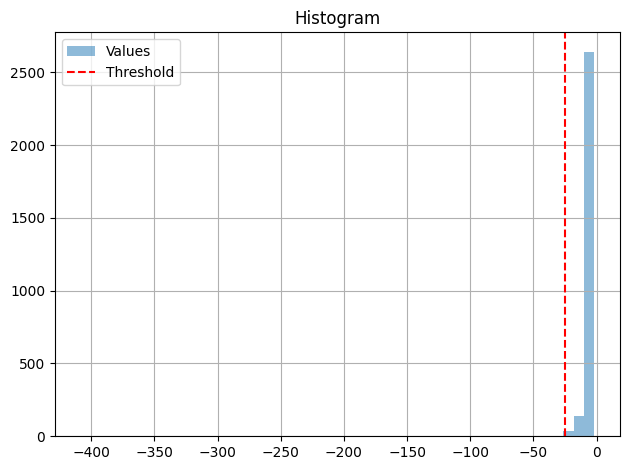

In [10]:
from src.models.statistical.linear_models import mvn_model
from src.visualization.plots import plot_hist

mvn = mvn_model(df[[0, 'pca1', 'pca2', 'pca3']])
train_scores_mvn = mvn.logpdf(df[[0, 'pca1', 'pca2', 'pca3']].values)
cutoff_mvn = np.percentile(train_scores_mvn, 1)

print(f'Minimum training score: {min(train_scores_mvn)}')
print(f'First Percentile cutoff: {cutoff_mvn}')
plot_hist(train_scores_mvn, threshold=cutoff_mvn)

### Evaluation

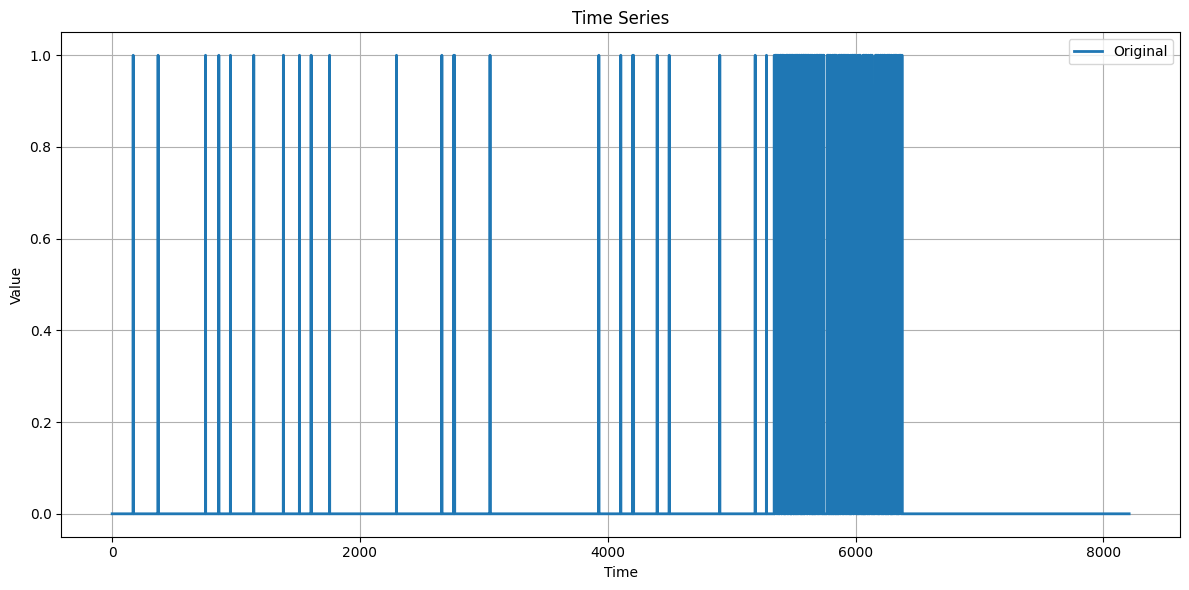

In [11]:
from src.visualization.plots import plot_ts

test_scores_mvn = mvn.logpdf(test[[0, 'pca1', 'pca2', 'pca3']].values)
mvn_anom = test_scores_mvn < cutoff_mvn

plot_ts(mvn_anom)

## CUSUM on continuos feature

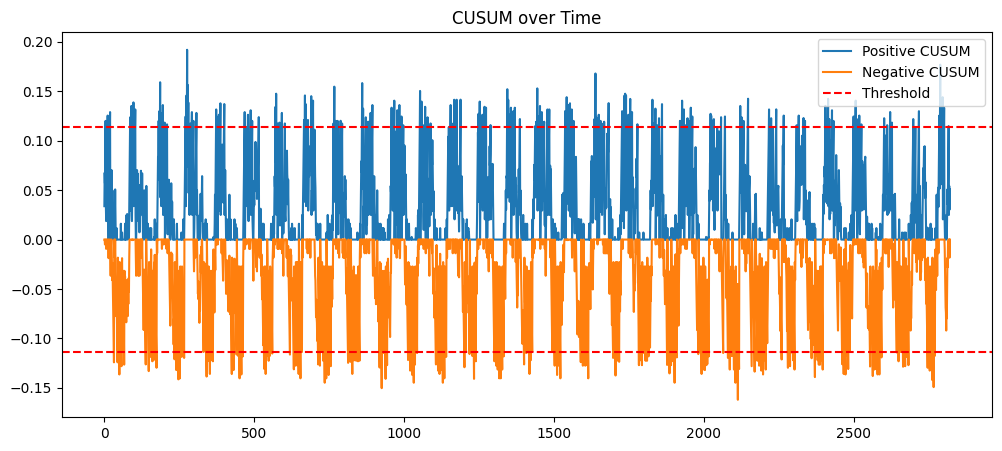

In [12]:
from src.models.statistical.rule_based import cusum

_ = cusum(df[0], plot=True)

### Evaluation

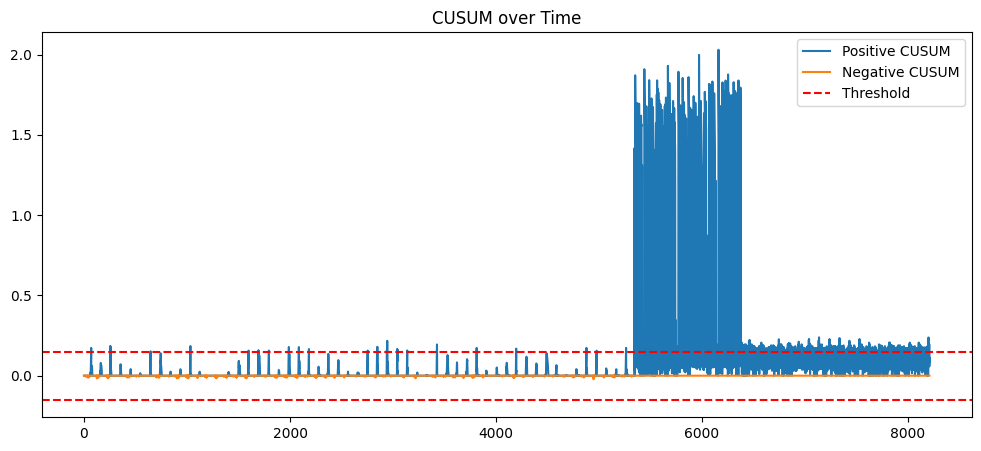

In [13]:
cusum_result = cusum(test[0], mean=df[0].mean(), threshold=0.15, plot=True)

## BOCPD



Use scipy logsumexp().


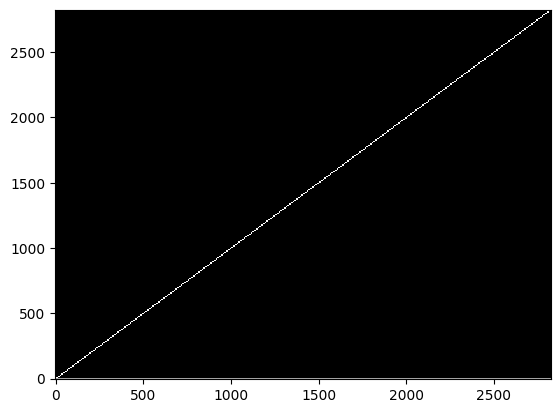

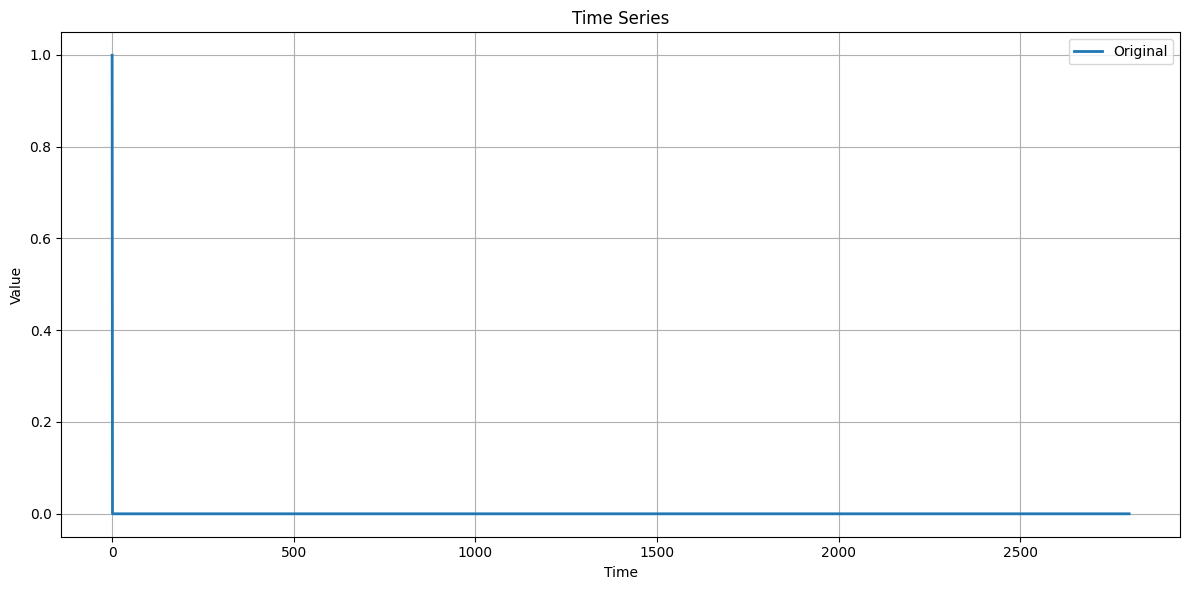

In [14]:
from functools import partial
from bayesian_changepoint_detection.hazard_functions import constant_hazard
from src.models.statistical.bayesian_models import bocpd

hazard_function = partial(constant_hazard, 1000)
bocpd(df[0], hazard_function, sparsity=10, Nw=20)



### Evaluation

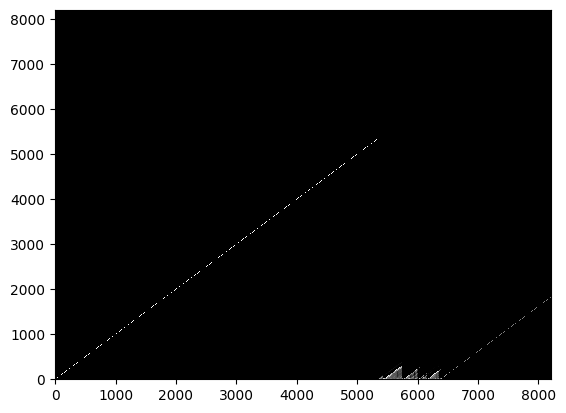

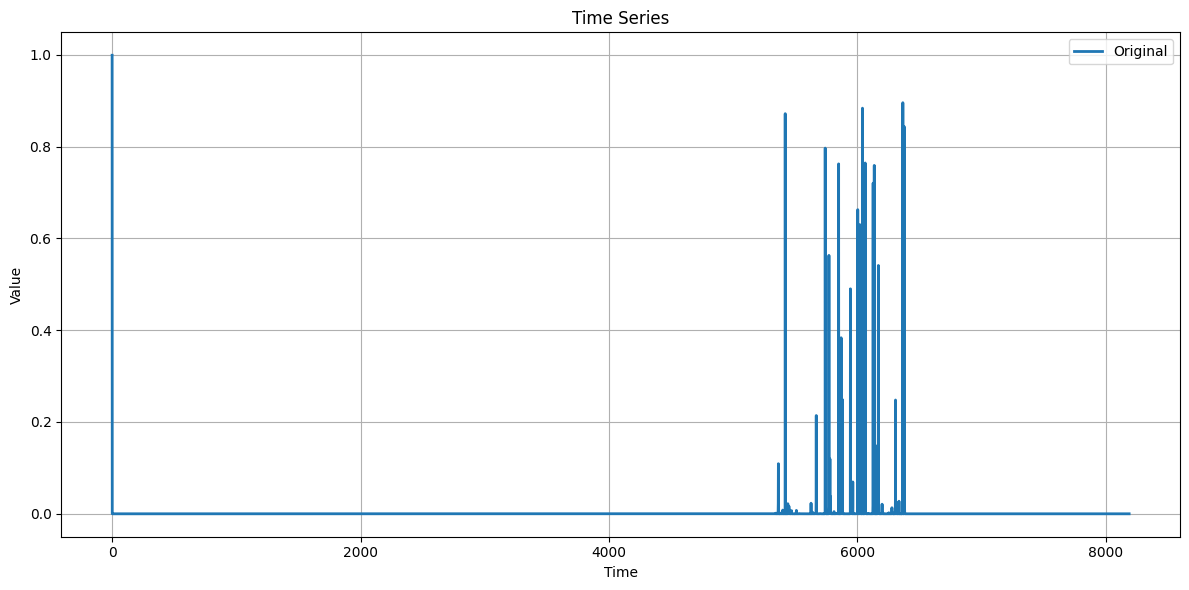

In [15]:
bocpd(test[0], hazard_function, sparsity=10, Nw=20)

# 3 Self-trained Machine Learning models

## LSTM Auto-Encoder

### Complex model
A LSTM model with `hidden_dim=8` is fitted to the time series.

In [4]:
from src.models.self_trained_ml.lstm_ae import model_LSTMAE

mse_LSTM = model_LSTMAE(df, window_size=200, batch_size=64, hidden_dim=64, latent_dim=64, learning_rate=0.01, epochs=50, plot_accuracy=True)

errors_ts = pd.Series(mse_LSTM.numpy(), index=df.index[200:])
plot_ts(errors_ts, title='MSE Errors')

ValueError: LSTM: Expected input to be 2D or 3D, got 4D instead

The same model is trained on `epochs=10` (the elbow of the accuracy plot) to avoid over fitting.

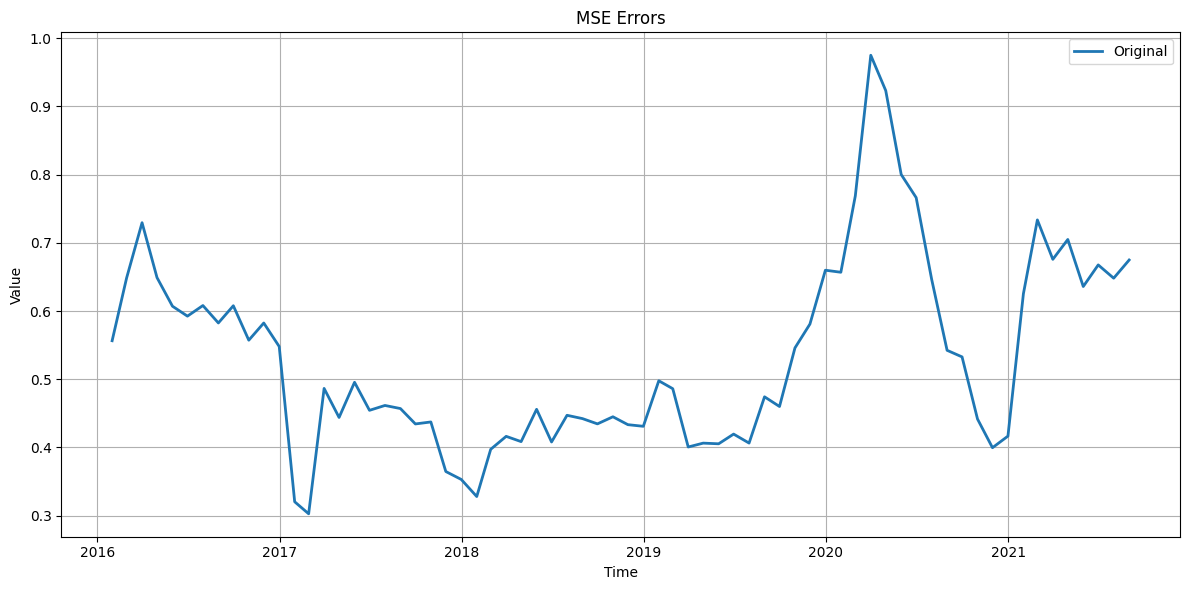

In [ ]:
mse_LSTM = model_LSTMAE(ts, window_size=12, batch_size=16, hidden_dim=8, latent_dim=8, learning_rate=0.01, epochs=10)

errors_ts = pd.Series(mse_LSTM.numpy(), index=ts.index[12:])
plot_ts(errors_ts, title='MSE Errors')

### Simple model
A LSTM model with `hidden_dim=2` is fitted to the time series.

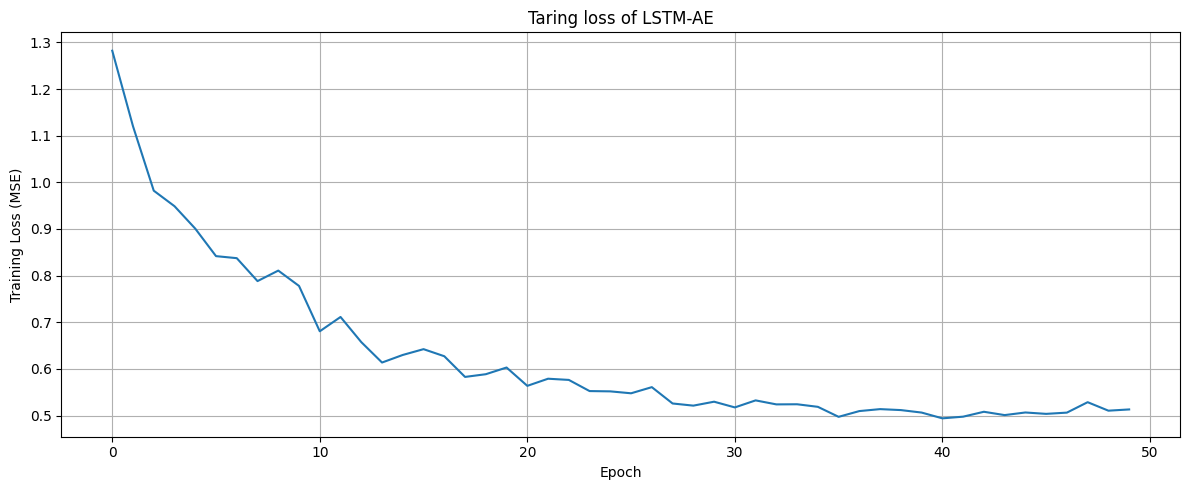

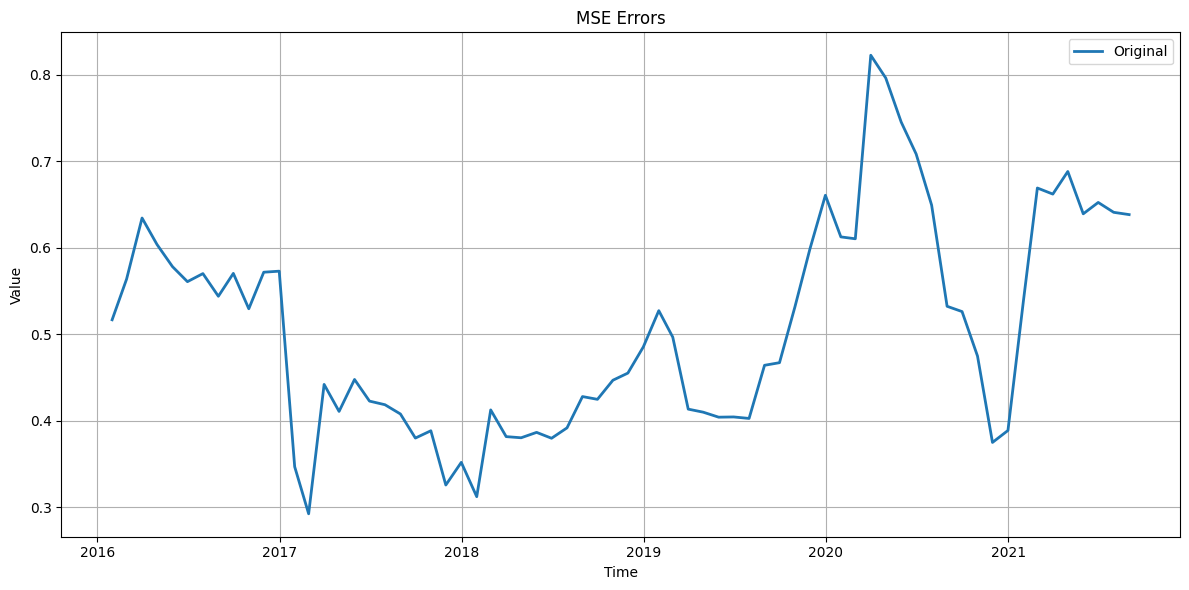

In [ ]:
mse_LSTM = model_LSTMAE(ts, window_size=12, batch_size=16, hidden_dim=2, latent_dim=2, learning_rate=0.01, epochs=50, plot_accuracy=True)

errors_ts = pd.Series(mse_LSTM.numpy(), index=ts.index[12:])
plot_ts(errors_ts, title='MSE Errors')

The same model is trained on `epochs=16` (the elbow of the accuracy plot) to avoid over fitting.

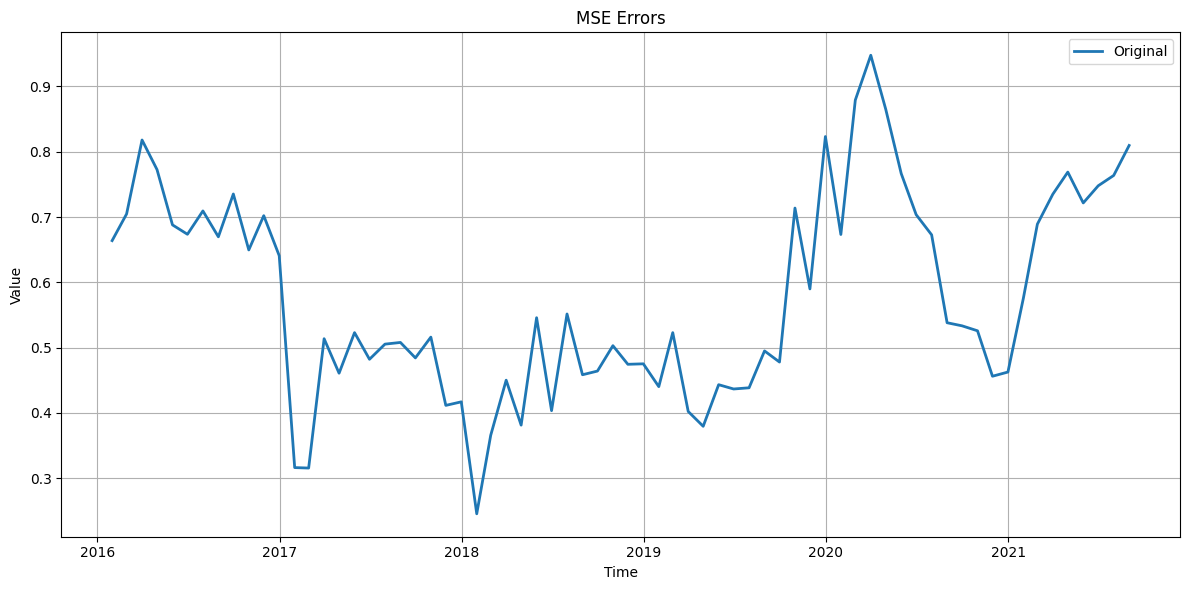

In [ ]:
mse_LSTM = model_LSTMAE(ts, window_size=12, batch_size=16, hidden_dim=2, latent_dim=2, learning_rate=0.01, epochs=16)

errors_ts = pd.Series(mse_LSTM.numpy(), index=ts.index[12:])
plot_ts(errors_ts, title='MSE Errors')

### LSTM Comparisons

Both the complex model (`hidden_dim=8`) and the simple model (`hidden_dim=2`) converge to a similar training loss of approximately $0.5$, indicating **no substantial difference** in their reconstruction capabilities.

In terms of anomaly detection behavior, both models exhibit similar error patterns:
- Mean squared error (MSE) peaks notably in early 2020,
- With additional elevated errors observed in 2016 and 2021.

These similarities suggest that increasing the model complexity **did not** lead to meaningful performance gains for this dataset.

## Isolation Forest

### Standard Features

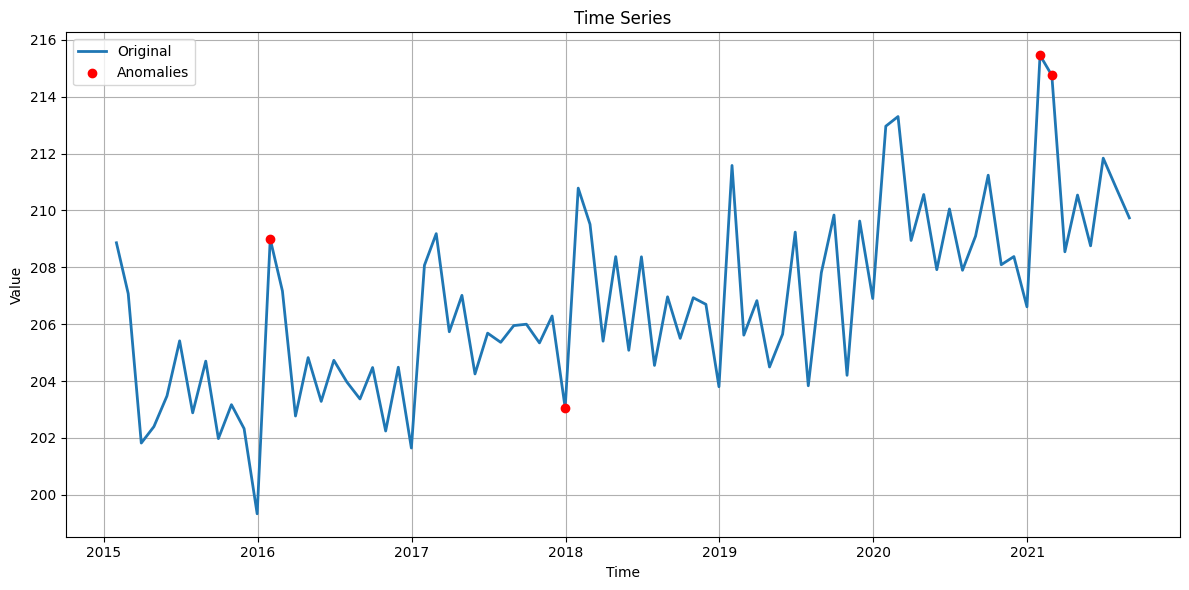

In [ ]:
from src.models.self_trained_ml.isolation_forest import model_isolation_forest
import numpy as np

def extract_features(windows) -> pd.DataFrame:
    features = []
    for w in windows:
        w = pd.Series(w)
        f = {
            'mean': w.mean(),
            'std': w.std(),
            'min': w.min(),
            'max': w.max(),
            'skew': w.skew(),
            'kurt': w.kurt(),
            'slope': np.polyfit(np.arange(len(w)), w.values, 1)[0],
        }
        features.append(f)
    return pd.DataFrame(features)

if_results = model_isolation_forest(ts, extract_features=extract_features, window_size=12)
plot_ts(ts, anom=if_results['anomaly'])

There is no clear clustering among the anomalies identified by the Isolation Forest. However, all four detected anomalies occur near seasonal peaks or troughs, suggesting that the model may be responding primarily to **normal seasonal variation**. This indicates that better feature engineering or seasonality-aware representations may be needed for more meaningful anomaly detection on this dataset.

### Seasonal Features
The following extract features function is modified to be more seasonality aware.

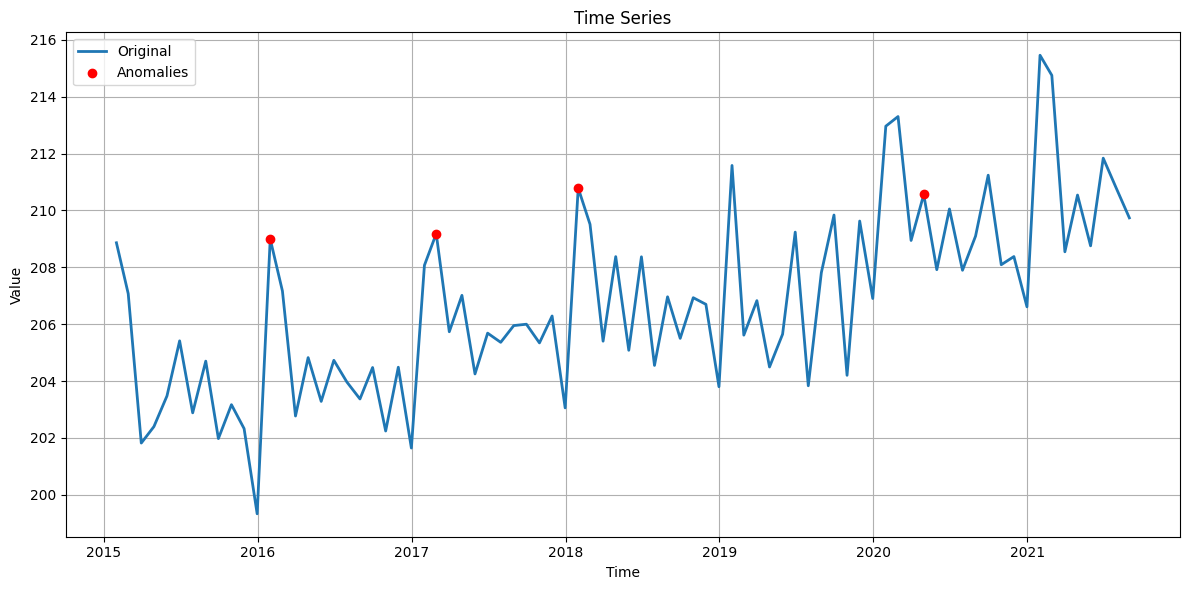

In [ ]:
def extract_features(windows) -> pd.DataFrame:
    features = []

    for w in windows:
        w = pd.Series(w)
        fft = np.fft.rfft(w - w.mean())
        f_abs = np.abs(fft)

        f = {
            'mean': w.mean(),
            'std': w.std(),
            'min': w.min(),
            'max': w.max(),
            'skew': w.skew(),
            'kurt': w.kurt(),
            'slope': np.polyfit(np.arange(len(w)), w.values, 1)[0],
            
            'acf_lag_1': w.autocorr(lag=1),
            'acf_lag_12': w.autocorr(lag=12) if len(w) >= 13 else 0,
            'fft_seasonal_power': f_abs[1] if len(f_abs) > 1 else 0,
            'fft_total_power': f_abs.sum(),
            'fft_ratio': f_abs[1]/f_abs.sum() if f_abs.sum() > 0 and len(f_abs) > 1 else 0,
        }

        features.append(f)

    return pd.DataFrame(features)

if_results = model_isolation_forest(ts, extract_features=extract_features, window_size=12)
plot_ts(ts, anom=if_results['anomaly'])

Similarly to the previous model, there is no clear clustering among the anomalies identified by the Isolation Forest. The identified anomalies also occur more often at the peaks of seasonality showing that this model does not preform well with strongly seasonal data.

## Autoencoders (binary input, binary cross-entropy loss)
Train a neural network to reconstruct binary inputs.

Use binary cross-entropy as the loss.

If a new observation reconstructs poorly (high loss), it’s an anomaly.

Works well when interactions or complex structure exists among features.

In [ ]:
loss = BinaryCrossEntropy(input, reconstruction)


# 4 Pretrained Models

## Prophet

c:\Users\tangj\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
09:50:55 - cmdstanpy - INFO - Chain [1] start processing
09:50:56 - cmdstanpy - INFO - Chain [1] done processing


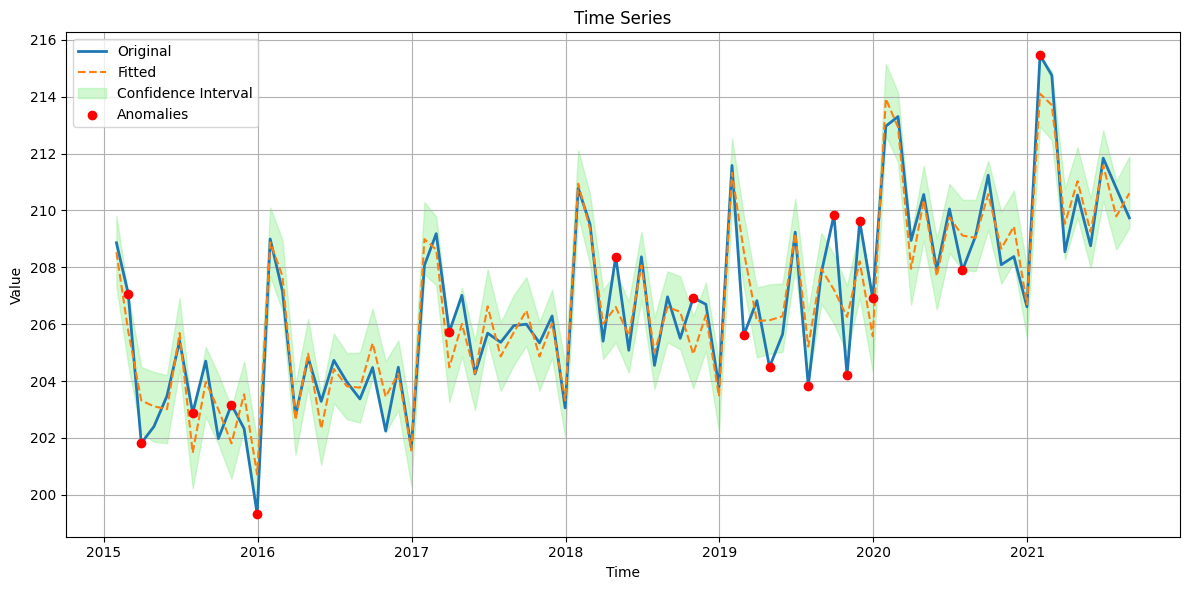

In [ ]:
from prophet import Prophet
from src.visualization.plots import plot_ts

prophet_df = pd.DataFrame({
    'ds': ts.index,  
    'y': ts.values 
})

model = Prophet()
model.fit(prophet_df)

prophet_pred = model.predict(prophet_df[['ds']].copy())

prophet_anom = (prophet_df['y'] < prophet_pred['yhat_lower']) | (prophet_df['y'] > prophet_pred['yhat_upper'])
prophet_anom = pd.Series(prophet_anom.values, index=ts.index)

prophet_CI = prophet_pred[['yhat_lower', 'yhat_upper']].copy()
prophet_CI.index = ts.index

plot_ts(ts, pd.Series(prophet_pred['yhat'].values, index=ts.index), CI=prophet_CI, anom=prophet_anom)

The prediction anomalies cluster in years 2015 and 2019, suggesting the time frames where the anomalies lie. Interestingly, the Prophet model identified much more prediction anomalies compared to the SARIMA models in section 2.

### Z-scores

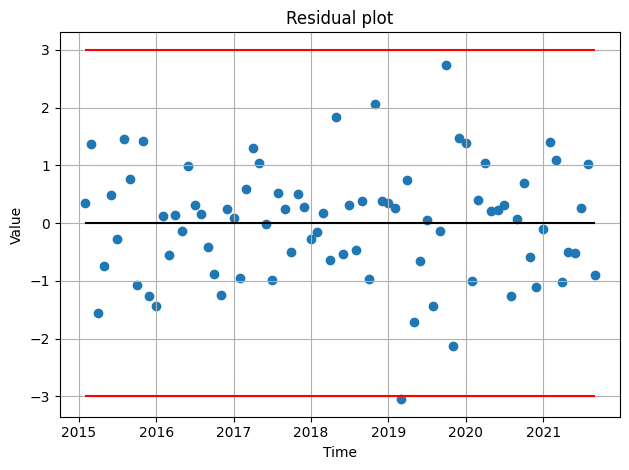

In [ ]:
from src.visualization.plots import plot_scatter
from src.models.preprocessing import standardize_residuals

prophet_resid = standardize_residuals(pd.Series(prophet_df['y'].values - prophet_pred['yhat'].values, index=ts.index))
plot_scatter(prophet_resid, hlines=[-3, 3])

The standardized residuals are evenly scattered around the x-axis, with a single outlier occurring at Feb 2019. 

# 4. Summary & Comparisons 

None of the models tested above were perfect in identifying the exact anomalies in the `short_seasonal` dataset. However, most were able to highlight regions of potential concern, offering useful insights into the data's behavior.

Encouragingly, **all models** except Isolation Forest flagged unusual behavior during 2019, which aligns with the known anomalies in the dataset.

The table below summarizes each model’s performance based on two criteria:
- Whether it correctly identified the known anomalies
- Whether it mistakenly flagged normal regions as anomalous


|Model|Anomalies Detected | False Positives|
|-------|-------------------------------|------------------|
|STL + Z-scores| Partially detected | None |
|STL + CUSUM| Partially detected| Some false positives|
|SARIMA + Prediction | Partially detected | None|
|SARIMA + Anomaly count| Partially detected | None |
|LSTM-AE | Largely detected | Some false positives |
|Isolation forest| Not detected | Some false positives |
|Prophet | Largely detected | Some false positives|